# Postprocess neutral ABL case

In [1]:
%%capture 
import sys, os, shutil
postproamrwinddir = '~/src/amr-wind-frontend/'
if postproamrwinddir not in sys.path:
    sys.path.append(postproamrwinddir)
# Load the libraries
import matplotlib.pyplot as plt
import postproamrwindabl as ppabl
import numpy             as np
from matplotlib import cm
import re
import time
import pandas as pd
import xarray as xr

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
def savecsvdata(d, savekeys, filename):
    # Create a new dictionary
    dfcsv = pd.DataFrame()
    for newkey,oldkey in savekeys.items():
        dfcsv[newkey] = d[oldkey]
    dfcsv.to_csv(filename,index=False,sep=',')
    return

def plot_profile(var,df,avgt):
    returndict = {}
    temp_dict = {}
    prof = ppabl.CalculatedProfile.fromdict(ppabl.statsprofiles[var],df,temp_dict,avgt=avgt)
    z, plotdat = prof.calculate()
    returndict[ppabl.statsprofiles[var]['header']] = {'z':z, 'data':plotdat}
    return returndict 

In [3]:
rundir='/nscratch/gyalla/HFM/exawind-benchmarks_gyalla/amr-wind/atmospheric_boundary_layer/neutral/runs/'
resultsdir='../results/'
casenames = [
  'AMR-Wind, Grid C',
  'AMR-Wind, Grid D',
]
caseparams = {}
caseparams[casenames[0]] = {'rundir':rundir + '/C_grid', 'saveprefix':'avgprofile_C','ncfile':'abl_statistics240000.nc', 'avgtimes':[120000,125000],'lstyle':{'color':'tab:blue',}}
caseparams[casenames[1]] = {'rundir':rundir + '/D_grid', 'saveprefix':'avgprofile_D','ncfile':'post_processing/abl_statistics480000.nc', 'avgtimes':[120000,125000],'lstyle':{'color':'tab:orange',}}

# Hub-height locations
plotheights=[27,90,153,175,200,250]
loadinmemory = False   # Do this only if there's enough RAM and for new (python 3+ netCDF4) libraries

In [4]:
dfs = {}
for case in casenames:
    print("Case: ",case)
    file = caseparams[case]['rundir'] + '/' + caseparams[case]['ncfile']
    df = ppabl.loadnetcdffile(caseparams[case]['rundir']+'/'+caseparams[case]['ncfile'], usemmap=loadinmemory)
    report = ppabl.printReport(df,avgt=caseparams[case]['avgtimes'], heights=plotheights,span=(27,153))
    dfs[case] = {}
    dfs[case]['df'] = df
    dfs[case]['report'] = report

Case:  AMR-Wind, Grid C
Loading u
Loading v'v'_r
Loading w'w'_r
Loading u'u'_r
Loading w'theta'_r
Loading v
Loading theta
        z       Uhoriz      WindDir       TI_TKE     TI_horiz        Alpha    Alpha-Fit     ObukhovL         Veer     Veer-Fit 
      ===         ====         ====         ====         ====         ====         ====         ====         ====         ==== 
    27.00 3.708206e+00 2.512376e+02 8.576047e-02 1.372803e-01 1.361276e-01 1.459290e-01 2.553476e+04 2.977003e-02 2.371547e-02 
    90.00 4.391980e+00 2.527041e+02 6.034973e-02 9.263573e-02 1.465347e-01 1.459290e-01 7.298625e+03 2.418350e-02 2.371547e-02 
   153.00 4.778414e+00 2.542837e+02 4.779809e-02 7.307615e-02 1.701005e-01 1.459290e-01 4.329382e+03 2.549453e-02 2.371547e-02 
   175.00 4.891523e+00 2.548359e+02 4.406486e-02 6.730979e-02 1.742311e-01 1.459290e-01 3.808723e+03 2.514261e-02 2.371547e-02 
   200.00 5.008495e+00 2.554880e+02 4.002792e-02 6.123848e-02 1.745819e-01 1.459290e-01 3.363388e+03 2.759098e

## Plot velocity profile

Loading u
Loading v


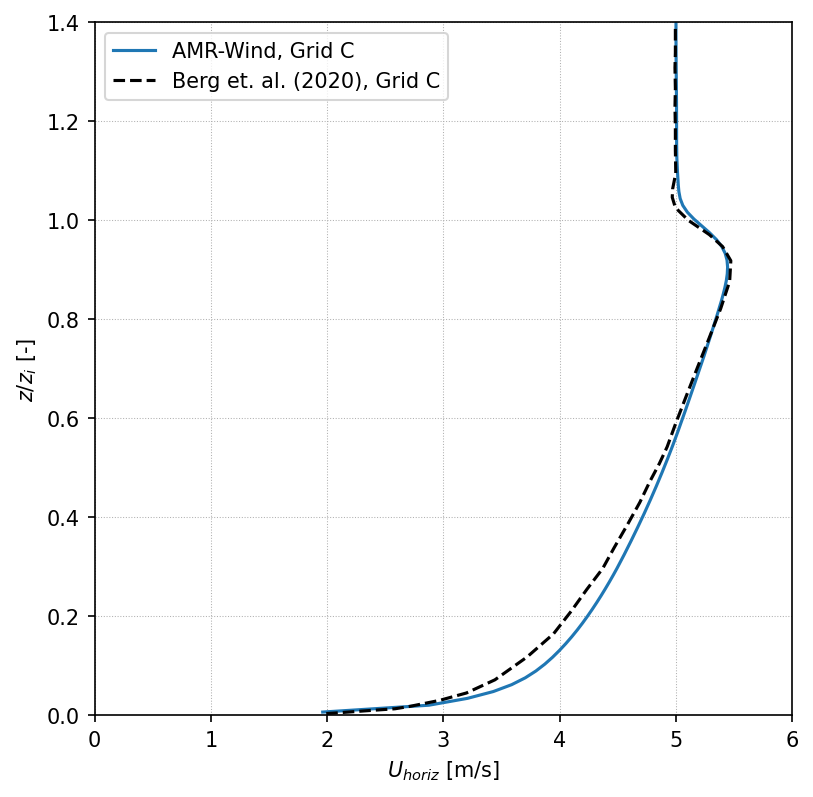

In [5]:
# Plot velocity
var='Uhoriz'
csvfiles = {}
csvfiles[casenames[0]] = ('../results/S_C_berg.csv','Berg et. al. (2020), Grid C')
csvfiles[casenames[1]] = ('../results/S_D_berg.csv','Berg et. al. (2020), Grid D')

fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color='k',ls='--',label=csvfiles[case][1])

ax.legend()
ax.set_xlim([0, 6])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$U_{horiz}$ [m/s]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_Uhoriz_C_grid.png")


Loading u
Loading v
Loading u
Loading v


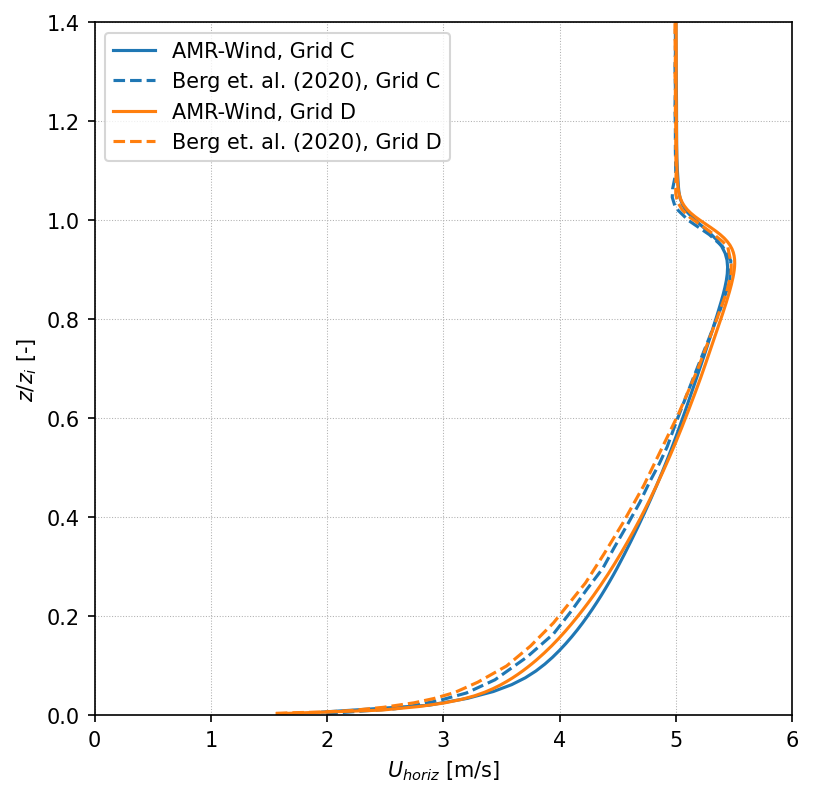

In [6]:


fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])
    if 'saveprefix' in caseparams[case]:
        savecsvdata(amrdat[var], {'z':'z', var:'data'}, resultsdir+caseparams[case]['saveprefix']+'_'+var+'.csv')


ax.legend()
ax.set_xlim([0, 6])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$U_{horiz}$ [m/s]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_Uhoriz_C_D_grids.png")

## Plot temperature profiles

Loading theta


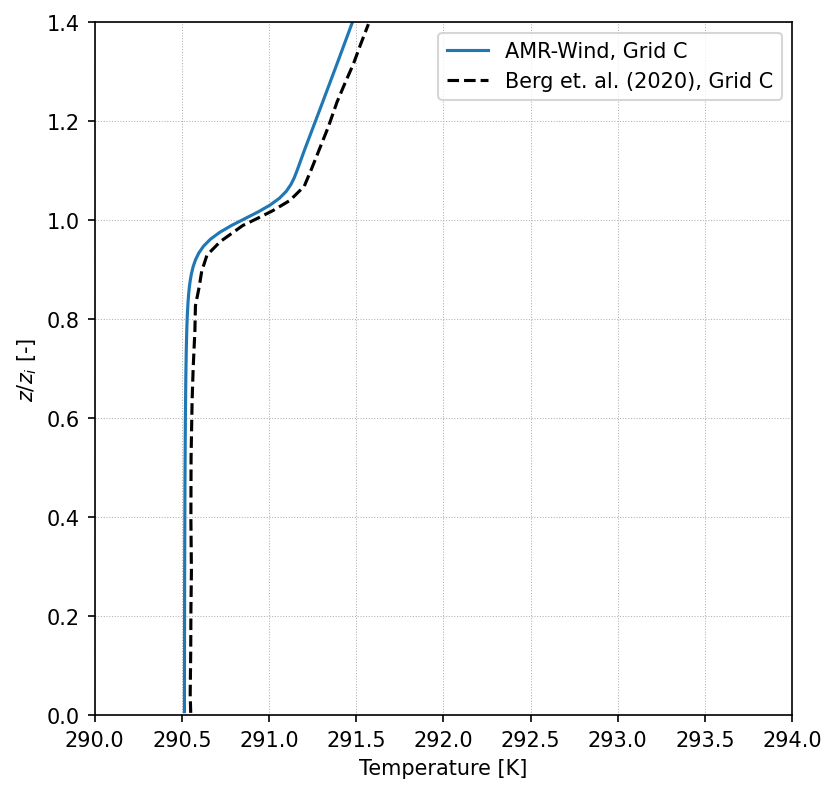

In [7]:
var = ('Temperature','T')
csvfiles = {}
csvfiles[casenames[0]] = ('../results/T_C_berg.csv','Berg et. al. (2020), Grid C')
csvfiles[casenames[1]] = ('../results/T_D_berg.csv','Berg et. al. (2020), Grid D')

fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var[0],df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var[1]]['data'], amrdat[var[1]]['z']/report['zi'], label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color='k',ls='--',label=csvfiles[case][1])


ax.legend()
ax.set_xlim([290, 294])
ax.set_ylim([0, 1.4])
ax.set_xlabel(var[0] + ' [K]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_T_C_grid.png")

Loading theta
Loading theta


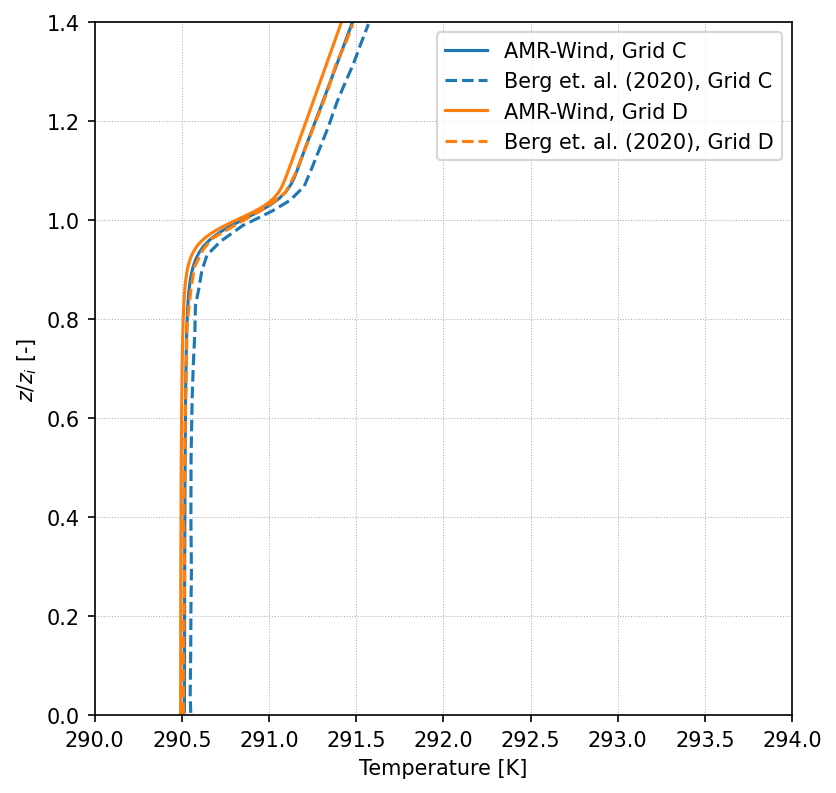

In [8]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var[0],df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var[1]]['data'], amrdat[var[1]]['z']/report['zi'], label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])
    if 'saveprefix' in caseparams[case]:
        savecsvdata(amrdat[var[1]], {'z':'z', var[1]:'data'}, resultsdir+caseparams[case]['saveprefix']+'_'+var[1]+'.csv')



ax.legend()
ax.set_xlim([290, 294])
ax.set_ylim([0, 1.4])
ax.set_xlabel(var[0] + ' [K]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_T_C_D_grids.png")

## Plot veer profile

Loading u
Loading v


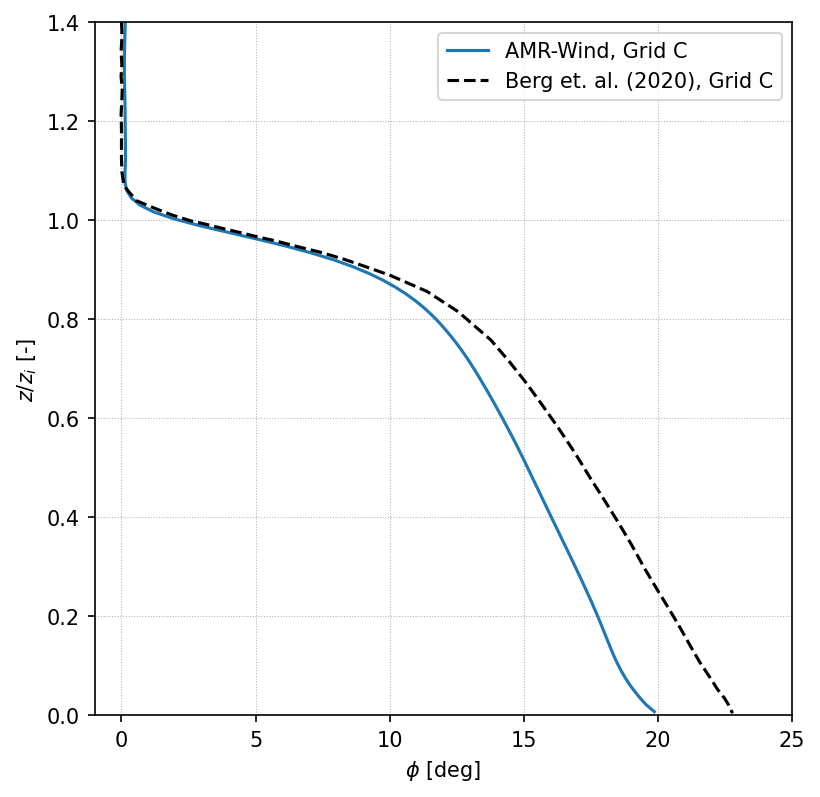

In [9]:
var='WindDir'
csvfiles = {}
csvfiles[casenames[0]] = ('../results/phi_C_berg.csv','Berg et. al. (2020), Grid C')
csvfiles[casenames[1]] = ('../results/phi_D_berg.csv','Berg et. al. (2020), Grid D')

fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(270-amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color='k',ls='--',label=csvfiles[case][1])


ax.legend()
ax.set_xlim([-1, 25])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$\phi$ [deg]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_WindDir_C_grid.png")


Loading u
Loading v
Loading u
Loading v


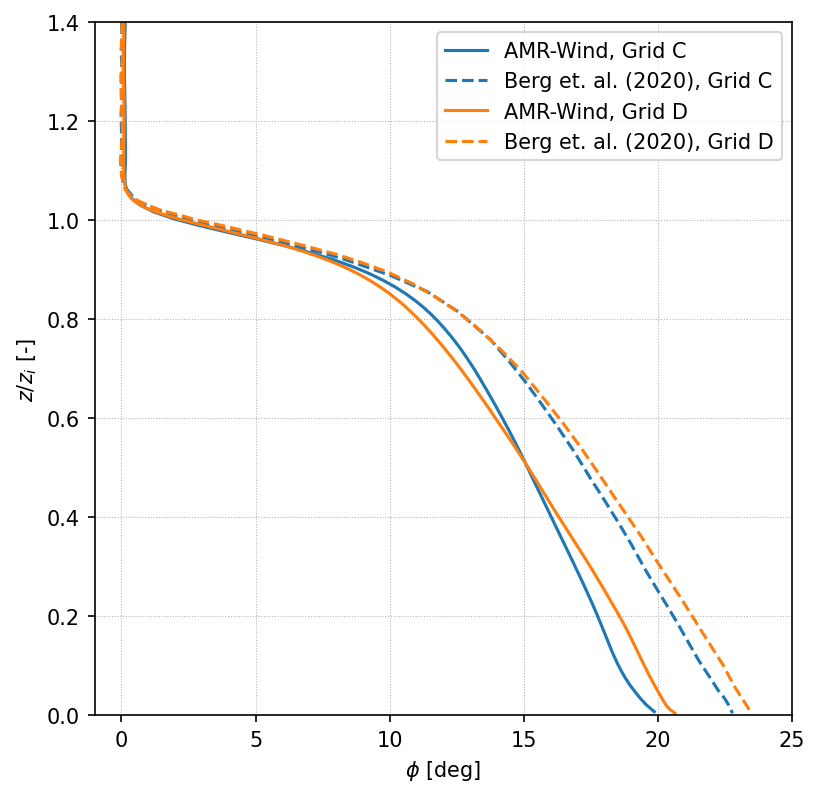

In [10]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(270-amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])
    if 'saveprefix' in caseparams[case]:
        savecsvdata(amrdat[var], {'z':'z', var:'data'}, resultsdir+caseparams[case]['saveprefix']+'_'+var+'.csv')
ax.legend()
ax.set_xlim([-1, 25])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$\phi$ [deg]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_WindDir_C_D_grids.png")


## Plot TI

Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r


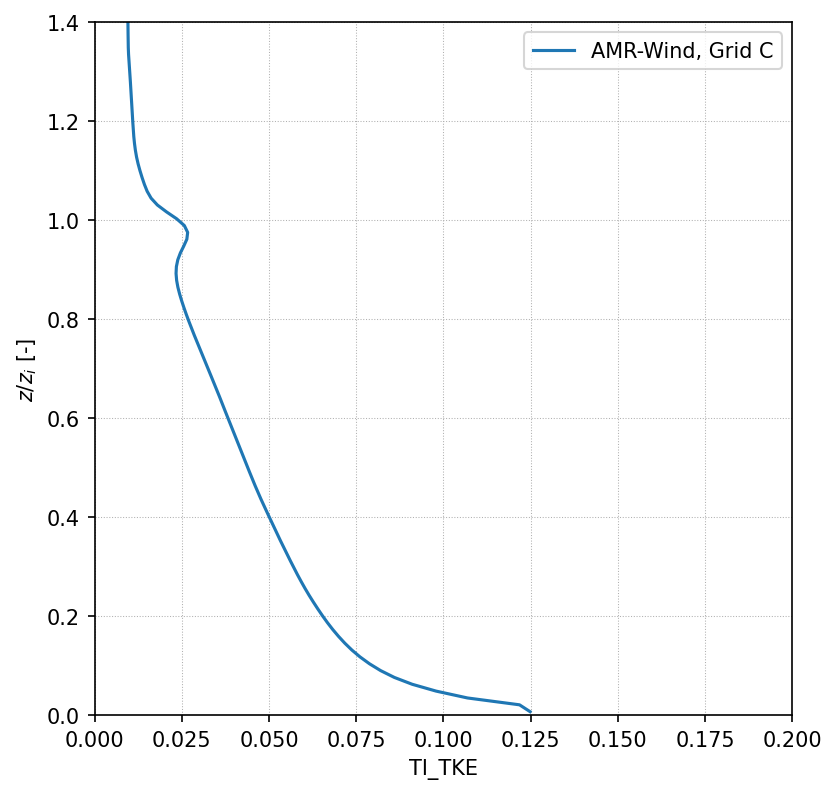

In [11]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
var = 'TI_TKE'
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
ax.legend()
ax.set_xlim([0, 0.2])
ax.set_ylim([0, 1.4])
ax.set_xlabel('TI_TKE')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_TI_C_grid.png")

Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r


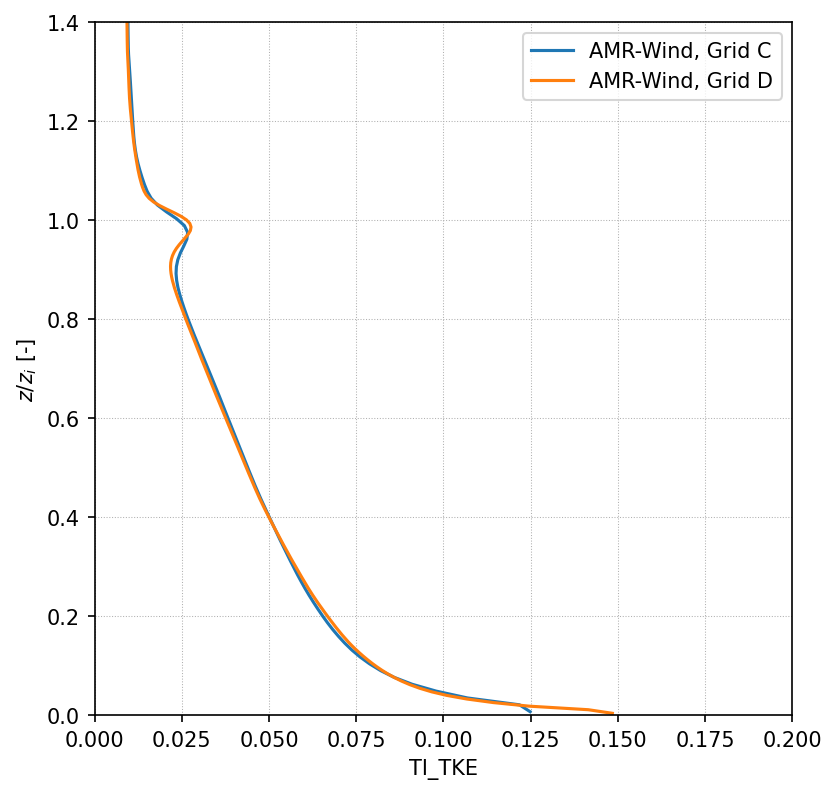

In [12]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
var = 'TI_TKE'
for case in casenames:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
    if 'saveprefix' in caseparams[case]:
        savecsvdata(amrdat[var], {'z':'z', var:'data'}, resultsdir+caseparams[case]['saveprefix']+'_'+var+'.csv')
ax.legend()
ax.set_xlim([0, 0.2])
ax.set_ylim([0, 1.4])
ax.set_xlabel('TI_TKE')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_TI_C_D_grids.png")

### Plot Reynolds Stress

Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r


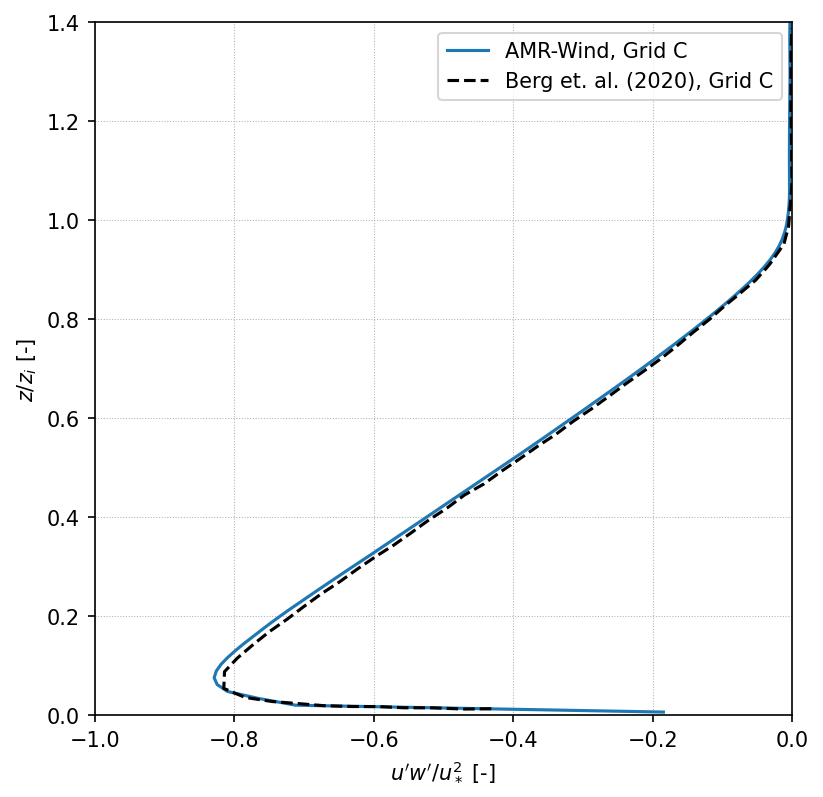

In [13]:
var = 'ReStresses'
csvfiles = {}
csvfiles[casenames[0]] = ('../results/uw_C_berg.csv','Berg et. al. (2020), Grid C')
csvfiles[casenames[1]] = ('../results/uw_D_berg.csv','Berg et. al. (2020), Grid D')

fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    uw = amrdat['uu uv uw vv vw ww']['data'][:,2]
    ustar = report['ustar']
    zi = report['zi']
    z = amrdat['uu uv uw vv vw ww']['z']
    lstyle=caseparams[case]['lstyle']
    plt.plot(uw/ustar**2, z/zi, label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color='k',ls='--',label=csvfiles[case][1])

ax.legend()
ax.set_xlim([-1.0, 0.0])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$u\'w\'/u_*^2$ [-]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_uw_C_grid.png")

Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r
Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r


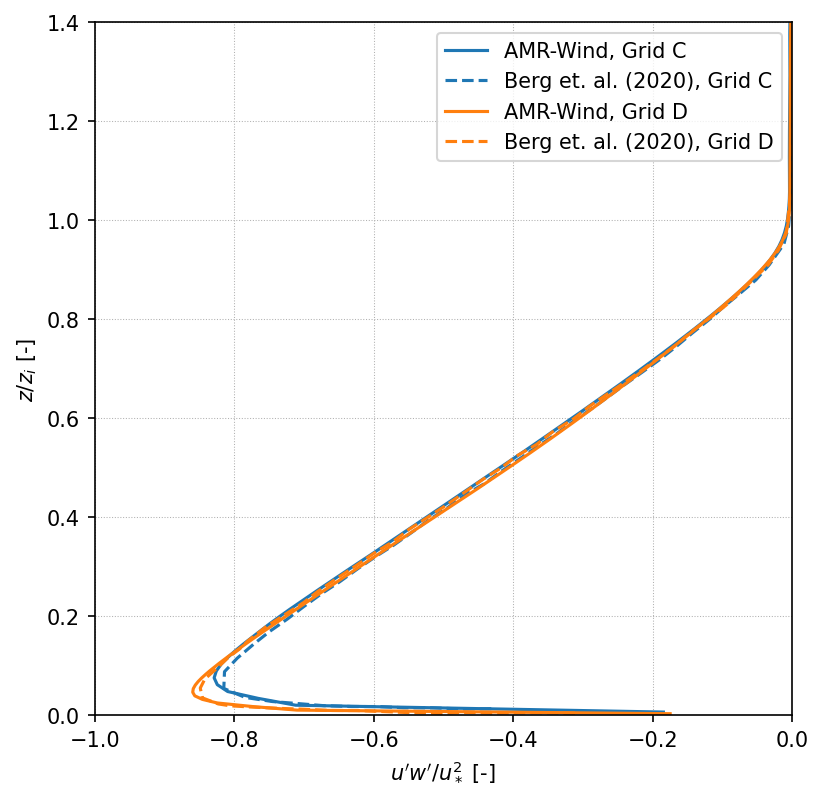

In [14]:

fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames:
    uw = {}
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    uw['data'] = amrdat['uu uv uw vv vw ww']['data'][:,2]
    uw['z'] = amrdat['uu uv uw vv vw ww']['z']
    ustar = report['ustar']
    zi = report['zi']
    z = amrdat['uu uv uw vv vw ww']['z']
    lstyle=caseparams[case]['lstyle']
    plt.plot(uw['data']/ustar**2, z/zi, label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])
    if 'saveprefix' in caseparams[case]:
        savecsvdata(uw, {'z':'z', var:'data'}, resultsdir+caseparams[case]['saveprefix']+'_'+var+'.csv')

ax.legend()
ax.set_xlim([-1.0, 0.0])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$u\'w\'/u_*^2$ [-]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_uw_C_D_grids.png")



Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r


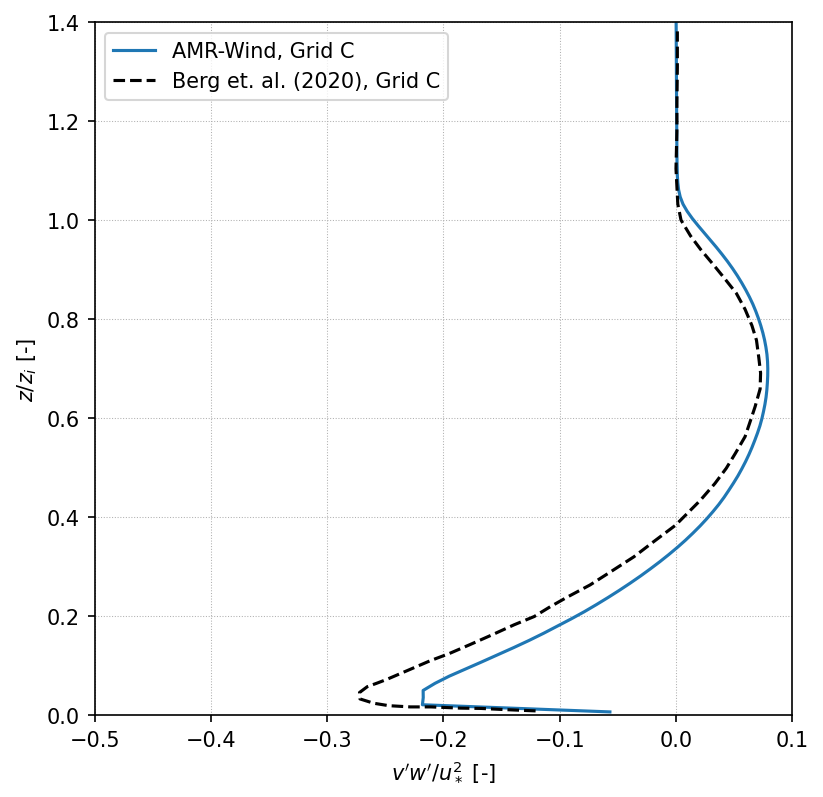

In [15]:
var = 'ReStresses'
csvfiles = {}
csvfiles[casenames[0]] = ('../results/vw_C_berg.csv','Berg et. al. (2020), Grid C')
csvfiles[casenames[1]] = ('../results/vw_D_berg.csv','Berg et. al. (2020), Grid D')

fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    vw = amrdat['uu uv uw vv vw ww']['data'][:,4]
    ustar = report['ustar']
    z = amrdat['uu uv uw vv vw ww']['z']
    lstyle=caseparams[case]['lstyle']
    plt.plot(vw/ustar**2, z/zi, label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color='k',ls='--',label=csvfiles[case][1])

ax.legend()
ax.set_xlim([-0.5, 0.1])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$v\'w\'/u_*^2$ [-]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_vw_C_grid.png")

Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r
Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r


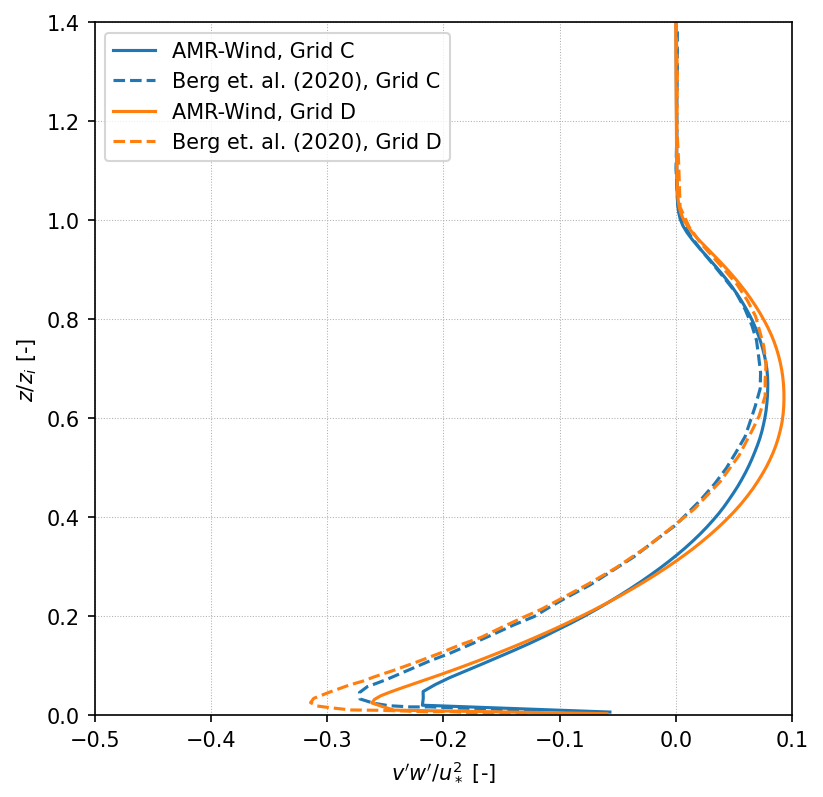

In [16]:

fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames:
    vw = {}
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    vw['data'] = amrdat['uu uv uw vv vw ww']['data'][:,4]
    vw['z'] = amrdat['uu uv uw vv vw ww']['z']
    ustar = report['ustar']
    zi = report['zi']
    z = amrdat['uu uv uw vv vw ww']['z']
    lstyle=caseparams[case]['lstyle']
    plt.plot(vw['data']/ustar**2, z/zi, label=case,**lstyle)
    compare_csv = pd.read_csv(csvfiles[case][0])
    plt.plot(compare_csv['y'],compare_csv['x'],color=lstyle['color'],ls='--',label=csvfiles[case][1])
    if 'saveprefix' in caseparams[case]:
        savecsvdata(vw, {'z':'z', var:'data'}, resultsdir+caseparams[case]['saveprefix']+'_'+var+'.csv')

ax.legend()
ax.set_xlim([-0.5, 0.1])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$v\'w\'/u_*^2$ [-]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_vw_C_D_grids.png")

